In [0]:
#Read me block:
#Dataset: MNIST;
#Metric: Clustering accuracy;
#Structures: MLP; 
#Status: Active;
#Work progress: Done;

In [0]:
from __future__ import print_function
import os
import subprocess
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import keras
import tarfile
from mpl_toolkits.mplot3d import Axes3D

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

Using TensorFlow backend.


In [0]:
# MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
#x_train = np.resize(x_train, (60000,28,28,1))
#x_test = np.resize(x_test, (10000,28,28,1))
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
train_dict = { "images": x_train, "labels":y_train}
test_dict = { "images": x_test, "labels":y_test}

def cast_and_normalise_images(data_dict):
 #Convert images to floating point with the range [-0.5, 0.5]
    images = data_dict['images']
    data_dict['images'] = (tf.cast(images, tf.float32) / 255.0) 
    return data_dict
  
data_variance = np.var(train_dict['images'] / 255.0)

11493376/11490434 [==============================] - 0s 0us/step


# Encoder-Decoder


if the padding type is SAME then:  output_shape = input_shape * stride
 if the padding type is VALID then: output_shape = input_shape * stride + kernel_shape - 1


In [0]:
class Encoder():
    def __init__(self, intermediate_dim, latent_dim, name='encoder'):
        self._intermediate_dim = intermediate_dim
        self._latent_dim = latent_dim
        
    def __call__(self, x):      
        h = tf.layers.dense(x, self._intermediate_dim[0], activation= tf.nn.relu, name = "enc_1")
        
        h = tf.layers.dense(h, self._intermediate_dim[1], activation= tf.nn.relu, name = "enc_2")
        
        h = tf.layers.dense(h, self._intermediate_dim[2], activation= tf.nn.relu, name = "enc_3")        
      
        z_mean = tf.layers.dense(h, self._latent_dim,name = "z_mean")
        
        z_log_var = tf.layers.dense(h, intermediate_dim[3],name = "z_log_var")
        
        return {'z_mean':z_mean, 
                'z_log_var':z_log_var}

class Decoder():
    def __init__(self, intermediate_dim, original_dim, name='decoder'):
        self._intermediate_dim= intermediate_dim
        self._original_dim = original_dim
        
    def __call__(self, x):
        h = tf.layers.dense(x, self._intermediate_dim[2], activation= tf.nn.relu,name = "dec_1")
        
        h = tf.layers.dense(h, self._intermediate_dim[1], activation= tf.nn.relu, name = "dec_2")
        
        h = tf.layers.dense(h, self._intermediate_dim[0], activation= tf.nn.relu, name = "dec_3")

        x_recon = tf.layers.dense(h, self._original_dim, activation= tf.sigmoid, name = "x_recon") 
        return x_recon

# Bottleneck Operations

In [0]:
def sampling(z_mean, z_log_var):
    sampling_dim = tf.shape(z_mean)
    epsilon = tf.random_normal(sampling_dim)
    return z_mean + tf.sqrt(tf.exp( z_log_var)) * epsilon
  
def information_dropout(z_mean, sigma=None, sigma0=1.):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    e = tf.random_normal([batch, dim])
    log_normal = tf.exp(sigma * sigma0 * e)
    return tf.multiply(z_mean, log_normal)
  
def soft_prob(dist, smooth):
  prob = tf.exp(-tf.multiply(dist, 0.5*smooth))/tf.sqrt(smooth)
  probs = prob/tf.expand_dims(tf.reduce_sum(prob, 1),1)
  return probs

def add_noise(input_signal, noise_level):
    dims = tf.shape(input_signal)
    noise = tf.random_normal(dims, stddev = noise_level)
    return input_signal + noise

# VQ-VAE & Soft VQ-VAE

In [0]:
class softVectorQuantizer():
    # b: batch size; q: number of channels; K: number of codewords; d:embedding_dim;

  def __init__(self, embedding_dim, num_embeddings, commitment_cost, name='vq_layer'):
    self._embedding_dim = embedding_dim
    self._num_embeddings = num_embeddings
    self._commitment_cost = commitment_cost
    
    initializer = tf.uniform_unit_scaling_initializer()
    self._w = tf.get_variable('embedding', [embedding_dim, num_embeddings],
                                initializer=initializer, trainable=True)

  def __call__(self, inputs, is_training):  
    #noisy
    #inputs['z_mean'] = add_noise(inputs['z_mean'], 0.01)
    
    # shpae: (b, w, h, q)
    input_shape = tf.shape(inputs['z_mean'])
    # Assert last dimension is same as self._embedding_dim
    with tf.control_dependencies([
        tf.Assert(tf.equal(input_shape[-1], self._embedding_dim),[input_shape])]):
      flat_inputs = tf.reshape(inputs['z_mean'], [-1, self._embedding_dim])

    # distances dimension: (b*q,K)
    # The distance has not been rooted.
    distances = (tf.reduce_sum(flat_inputs**2, 1, keepdims=True)
                 - 2 * tf.matmul(flat_inputs, self._w)
                 + tf.reduce_sum(self._w ** 2, 0, keepdims=True))
    
    
    #soft operations
    smooth = 1./tf.exp(inputs['z_log_var'])**2
    #expected shape: (b*q,K)
    probs = soft_prob(distances, smooth)
    #expected shape: (b*q,1,k)
    probs = tf.expand_dims(probs, 1)
    #expected shape: (1,d,k)
    codebook = tf.expand_dims(self._w, 0)
    #expected shape (b*q,d)
    quantize_vector = tf.reduce_sum(codebook*probs,2)
    quantized = tf.reshape(quantize_vector, tf.shape(inputs['z_mean']))
    
    # VQ-VAE operations
    #shape: q*b
    #encoding_indices = tf.argmax(- distances, 1)
    #encodings = tf.one_hot(encoding_indices, self._num_embeddings)
    #reshape to: (b,h,w), where q=h*w
    #encoding_indices = tf.reshape(encoding_indices, tf.shape(inputs['z_mean'])[:-1])
    #shape: (b,h,w,latent_dims)
    #quantized = self.quantize(encoding_indices)

    e_latent_loss = tf.reduce_mean((tf.stop_gradient(quantized) - inputs['z_mean']) ** 2)
    q_latent_loss = tf.reduce_mean((quantized - tf.stop_gradient(inputs['z_mean'])) ** 2)
    loss = q_latent_loss + self._commitment_cost * e_latent_loss

    quantized = inputs['z_mean'] + tf.stop_gradient(quantized - inputs['z_mean'])

    return {'quantize': quantized,
            'loss': loss}

  @property
  def embeddings(self):
    return self._w

  def quantize(self, encoding_indices):
    with tf.control_dependencies([encoding_indices]):
      w = tf.transpose(self.embeddings.read_value(), [1, 0])
    return tf.nn.embedding_lookup(w, encoding_indices, validate_indices=False)

# Define the graph


In [0]:
# Build dataset iterators
tf.reset_default_graph()
batch_size = 64

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(train_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()
def get_images(sess):
  return sess.run(train_dataset_batch)

testset_iterator = (
    tf.data.Dataset.from_tensor_slices(test_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(10000)).make_initializable_iterator()
test_dataset_batch = testset_iterator.get_next()
def test_images(sess):
  return sess.run(test_dataset_batch)  

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
num_embeddings = 128
latent_dim = 64  #set 2 if need to see visualization
commitment_cost = 2.5

#VQ-VAE
intermediate_dim = [500,500,2000,num_embeddings]
#Other models
#intermediate_dim = [500,500,2000,latent_dim]

# Build modules.
encoder = Encoder(intermediate_dim, latent_dim)
decoder = Decoder(intermediate_dim, original_dim)
vq_vae = softVectorQuantizer(
    embedding_dim=latent_dim,
    num_embeddings=num_embeddings,
    commitment_cost=commitment_cost)

# Encoder
x = tf.placeholder(tf.float32, shape=(None, original_dim))
output_encoder = encoder(x)

# Bottleneck
#AE
output_bottleneck = output_encoder['z_mean']
#VAE
#output_bottleneck = sampling(output_encoder['z_mean'], output_encoder['z_log_var'])
#information dropout
#output_bottleneck = information_dropout(output_encoder['z_mean'], sigma = 0.7*output_encoder['z_log_var'])
#VQ-VAE
z = vq_vae(output_encoder, is_training=True)
output_bottleneck = z["quantize"]

# Decoder
#AE
#VAE
#Information Dropout
#VQ-VAE
x_recon = decoder(output_bottleneck)
#Recon_Loss
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance # Normalized MSE

#Total loss
#AE
#loss = recon_error
#VAE
#kl_loss = -0.5*tf.reduce_sum(1.0 + output_encoder['z_log_var'] - tf.square(output_encoder['z_mean']) - tf.exp(output_encoder['z_log_var']),axis = 1)
#loss = original_dim*recon_error + 20.0*tf.reduce_mean(kl_loss)
#information dropout
#dropout_cost = -tf.reduce_mean(tf.log(output_encoder['z_log_var']/0.7+0.001))
#loss = original_dim*recon_error+0.5*dropout_cost
#VQ-VAE
loss = recon_error + 3.0*z["loss"]

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Use keras.layers.dense instead.


#Training 

In [0]:
learning_rate = 3e-4
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(loss)

sess = tf.train.SingularMonitoredSession()

train_res_recon_error = []

num_training_updates = 40000

for i in xrange(num_training_updates):
  feed_dict = {x: get_images(sess)['images']}
  if i!=num_training_updates:
    results = sess.run([train_op, recon_error],
                       feed_dict=feed_dict)
    train_res_recon_error.append(results[1])
  else:
    results = sess.run([train_op, recon_error],
                       feed_dict=feed_dict)
    train_res_recon_error.append(results[1])
  if (i+1) % 100 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    print()

Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
100 iterations
recon_error: 1.089

200 iterations
recon_error: 0.667

300 iterations
recon_error: 0.624

400 iterations
recon_error: 0.573

500 iterations
recon_error: 0.543

600 iterations
recon_error: 0.508

700 iterations
recon_error: 0.474

800 iterations
recon_error: 0.446

900 iterations
recon_error: 0.424

1000 iterations
recon_error: 0.390

1100 iterations
recon_error: 0.376

1200 iterations
recon_error: 0.365

1300 iterations
recon_error: 0.352

1400 iterations
recon_error: 0.334

1500 iterations
recon_error: 0.320

1600 iterations
recon_error: 0.318

1700 iterations
recon_error: 0.308

1800 iterations
recon_error: 0.292

1900 iterations
recon_error: 0.284

2000 iterations
recon_error: 0.279

2100 iterations
recon_error: 0.276

2200 iterations
recon_error: 0.271

2300 iterations
recon_error: 0.267

2400 iteratio

(-0.5, 223.5, 111.5, -0.5)

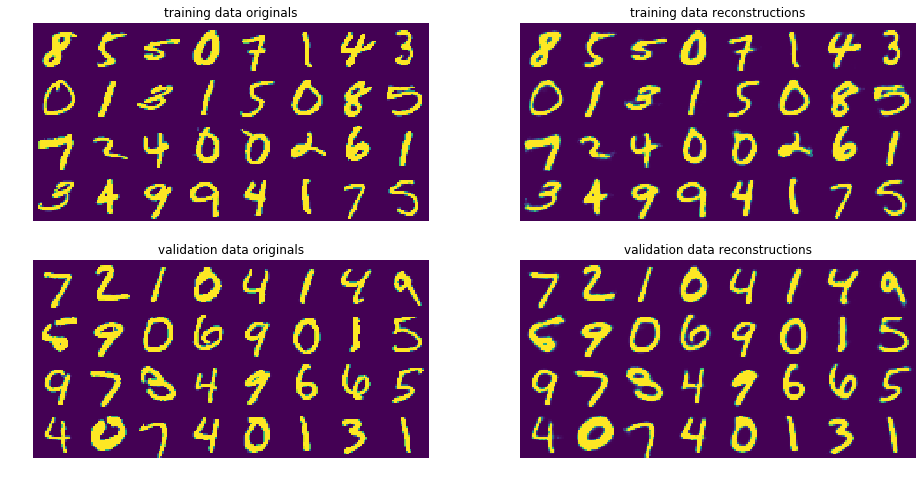

In [0]:
train_originals = get_images(sess)['images'][0:32,:]
feed_dict = {x: train_originals}
train_reconstructions = sess.run([x_recon], feed_dict=feed_dict)
sess.run(testset_iterator.initializer)
test_originals = test_images(sess)['images'][0:32,:]
feed_dict = {x: test_originals}
test_reconstructions = sess.run([x_recon] ,feed_dict=feed_dict)

import matplotlib.pyplot as plt
def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 28, 28, 1)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 28, 8 * 28, 1))
  reshaped+=0.5
  for i in range(reshaped.shape[0]):
    for j in range(reshaped.shape[1]):
      for k in range(reshaped.shape[2]):
        if reshaped[i,j,k]>1:
          reshaped[i,j,k]=1
        elif reshaped[i,j,k]<0:
          reshaped[i,j,k]=0        
  return reshaped
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(np.resize(convert_batch_to_image_grid(train_originals), (112, 224)),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(np.resize(convert_batch_to_image_grid(train_reconstructions[0]),(112,224)),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(np.resize(convert_batch_to_image_grid(test_originals), (112, 224)),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(np.resize(convert_batch_to_image_grid(test_reconstructions[0]),(112,224)),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')

In [0]:
sess.run(testset_iterator.initializer)
batch = test_images(sess)
encodings = []
labels = []
useage = []

feed_dict = {x: batch['images']}
encodings = sess.run(output_encoder['z_mean'], feed_dict = feed_dict)
labels = batch['labels']

# Latent Visualization

In [0]:
#color_list = np.array(['b0','b1','g0','g1','r','c','m','y','k','w'])
plt.figure(figsize=(10, 8)) 
plt.scatter(encodings[:, 0], encodings[:, 1],c=batch['labels'],cmap='tab10')
plt.colorbar()
plt.grid()
plt.show()

# Clustering

In [0]:
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.cluster import KMeans
def cluster_acc(y_true, y_pred):
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max())+1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        ind = linear_assignment(w.max() - w)
        return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w
      
labels= np.asarray(labels)
y_true = np.reshape(labels, (-1,))
encodings = np.asarray(encodings)
latent_features = np.reshape(encodings,(-1,latent_dim))
kmeans = KMeans(n_clusters=10, n_init=100)
y_pred = kmeans.fit_predict(latent_features)
acc = cluster_acc(y_true, y_pred)[0]
acc

0.7804